In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix,mean_absolute_error
from sklearn.decomposition import PCA


# Loading Dataset

In [17]:
data_file = '/media/amlan/Data/Thesis Data/Processed Data/kmeans_train_data'
df = pd.read_csv(data_file, index_col=0)
df = df.reset_index(drop=True)


df = df[df.Behavior != 'No observation']
df = df[df.VeDBA > 1e-6]
df.VeDBA  = np.log(df.VeDBA)
df = df.rename(columns={'VeDBA': 'Log VeDBA'})


df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.reset_index(drop=True,inplace=True)
df.Behavior.value_counts()

Scrabbling                        3067
Foraging                          1783
Bipedal vigilance                  782
RunningGPS                         413
Self groom                         249
Reforage                           184
Haunch quadrupedal vigilance       139
Standing quadrupedal vigilance     125
Social                             114
Sitting vigilance                  104
Processing                          71
Walking                             63
Running                             26
Marking                              4
Others                               2
Name: Behavior, dtype: int64

# Grouping Behavior

In [18]:
df.loc[df['Behavior'] == 'Sitting vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Bipedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Haunch quadrupedal vigilance','Behavior'] = 'Vigilance'
df.loc[df['Behavior'] == 'Standing quadrupedal vigilance','Behavior'] = 'Vigilance'


df.loc[df['Behavior'] == 'Scrabbling','Behavior'] = 'Foraging' #Change
df.loc[df['Behavior'] == 'Walking','Behavior'] = 'Foraging'
df.loc[df['Behavior'] == 'Reforage','Behavior'] = 'Foraging'

df.loc[df['Behavior'] == 'Social','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Processing','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Self groom','Behavior'] = 'Others'
df.loc[df['Behavior'] == 'Marking','Behavior'] = 'Others'



for i in df.Behavior.unique():
    print(str(i) + ' Log VeDBA Mean: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].mean())
    print(  str(i) + ' Log VeDBA Var: ',df.loc[df['Behavior'] == str(i),'Log VeDBA'].var())
    print('\n')

Vigilance Log VeDBA Mean:  -2.729864341940658
Vigilance Log VeDBA Var:  1.1781458497503823


Foraging Log VeDBA Mean:  -0.8345820375065527
Foraging Log VeDBA Var:  0.16040488815145565


Others Log VeDBA Mean:  -1.438911435278833
Others Log VeDBA Var:  0.4076083263089866


Running Log VeDBA Mean:  0.23845228351263487
Running Log VeDBA Var:  0.13594989002137692


RunningGPS Log VeDBA Mean:  0.4084134038507049
RunningGPS Log VeDBA Var:  0.25861514850981304




In [19]:
df.loc[df['Behavior'] == 'Walking','Behavior'] = 'Foraging'
df.Behavior.value_counts()

Foraging      5097
Vigilance     1150
Others         440
RunningGPS     413
Running         26
Name: Behavior, dtype: int64

Text(0.5, 1.0, 'VeDBA Distribution Across Behavior')

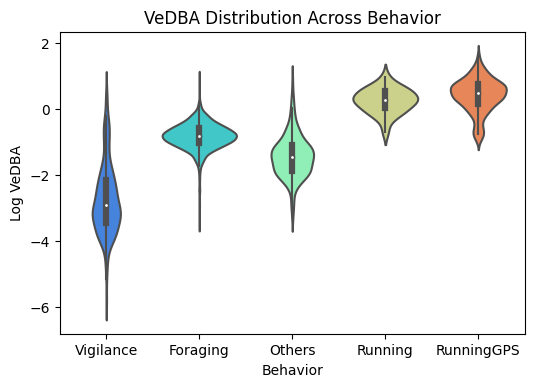

In [20]:
import seaborn as sns

#MAKE VIOLIN PLOTS


fig,ax = plt.subplots(dpi=100)
sns.violinplot(x='Behavior',y='Log VeDBA',data=df[['Behavior','Log VeDBA']], palette='rainbow',showfliers=True)
plt.title("VeDBA Distribution Across Behavior")

In [15]:
#df = df[~((df['Behavior'] == 'Foraging') & (df['Log VeDBA']<-2))]

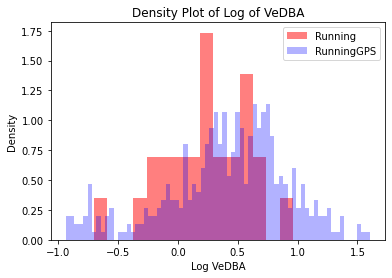

In [21]:
#plt.hist(np.log(df.loc[df['Behavior'] != 'Running','StdNorm']),bins=50,color='b',density='True')
plt.hist(df.loc[df['Behavior'] == 'Running','Log VeDBA'],bins=15,color='r',label='Running',density='True',alpha = .5) 
plt.hist(df.loc[df['Behavior'] == 'RunningGPS','Log VeDBA'],bins=70,color='b',label='RunningGPS',density='True',alpha=0.3)
plt.title('Density Plot of Log of VeDBA')
plt.xlabel('Log VeDBA')
plt.ylabel('Density')
plt.legend()
plt.show()
#df.loc[df['Behavior'] == 'RunningGPS','Behavior'] = 'Running'


In [22]:
df.Behavior.value_counts()

Foraging      5097
Vigilance     1150
Others         440
RunningGPS     413
Running         26
Name: Behavior, dtype: int64

# Random Forest

<ipython-input-23-c02d7178ee4b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'


Accuracy: 0.9670131043831902


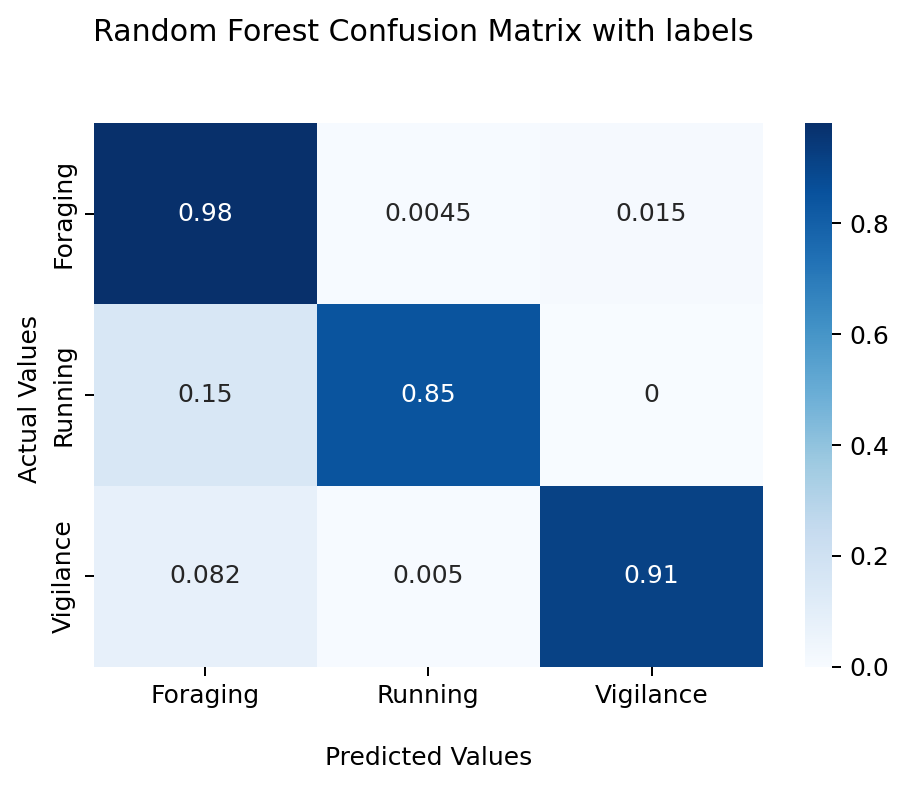

              precision    recall  f1-score   support

    Foraging       0.98      0.98      0.98      1786
     Running       0.69      0.85      0.76        26
   Vigilance       0.93      0.91      0.92       401

    accuracy                           0.97      2213
   macro avg       0.87      0.91      0.89      2213
weighted avg       0.97      0.97      0.97      2213



In [23]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.metrics import confusion_matrix,accuracy_score,plot_confusion_matrix,classification_report
from sklearn.decomposition import PCA

df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',
df_GPS_RUNNING = df_copy[df_copy['Behavior']=='RunningGPS']
df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'

df_RUNNING =  df_copy[df_copy['Behavior']=='Running']

df_copy = df_copy[df_copy['Behavior']!='RunningGPS']
df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

x=df_copy.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df_copy['Behavior'].values  # Labels


Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35,random_state=42) # 80% training and 20% test



clf=RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)


X_train =  np.concatenate((X_train, df_GPS_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_train = np.concatenate([y_train,df_GPS_RUNNING['Behavior'].to_numpy()],axis=0)


X_test =  np.concatenate((X_test, df_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_test = np.concatenate([y_test,df_RUNNING['Behavior'].to_numpy()],axis=0)

X_train = Scaler.fit_transform(X_train)

clf.fit(X_train,y_train)


X_test = Scaler.transform(X_test)

y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Random Forest Confusion Matrix with labels \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y_train)))
ax.yaxis.set_ticklabels(sorted(np.unique(y_train)))
#plt.tight_layout()
plt.show()


print(classification_report(y_test, y_pred))

In [24]:
from sklearn.pipeline import make_pipeline
import joblib

df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)


df_copy.loc[df_copy['Behavior']=='RunningGPS','Behavior'] = 'Running'

df_copy = df_copy[df_copy['Behavior']!='Others']

x=df_copy.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df_copy['Behavior'].values  # Labels
print(np.unique(y))

pipeline = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42) )

pipeline.fit(X_train, y_train)
print(classification_report(y_test,pipeline.predict(X_test)))

pipeline.fit(x, y)
joblib.dump(pipeline, '/media/amlan/Data/Thesis Data/Processed Data/RF_model.mod') 

['Foraging' 'Running' 'Vigilance']
              precision    recall  f1-score   support

    Foraging       0.98      0.98      0.98      1786
     Running       0.69      0.85      0.76        26
   Vigilance       0.93      0.91      0.92       401

    accuracy                           0.97      2213
   macro avg       0.87      0.91      0.89      2213
weighted avg       0.97      0.97      0.97      2213



['/media/amlan/Data/Thesis Data/Processed Data/RF_model.mod']

In [25]:
np.unique(y)

array(['Foraging', 'Running', 'Vigilance'], dtype=object)

In [26]:
pipeline = joblib.load('/media/amlan/Data/Thesis Data/Processed Data/RF_model.mod')
np.unique(pipeline.predict(X_train))

/home/amlan/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array(['Foraging', 'Running', 'Vigilance'], dtype=object)

Leave One Out Analysis For Group

Accuracy: 0.9840764331210191


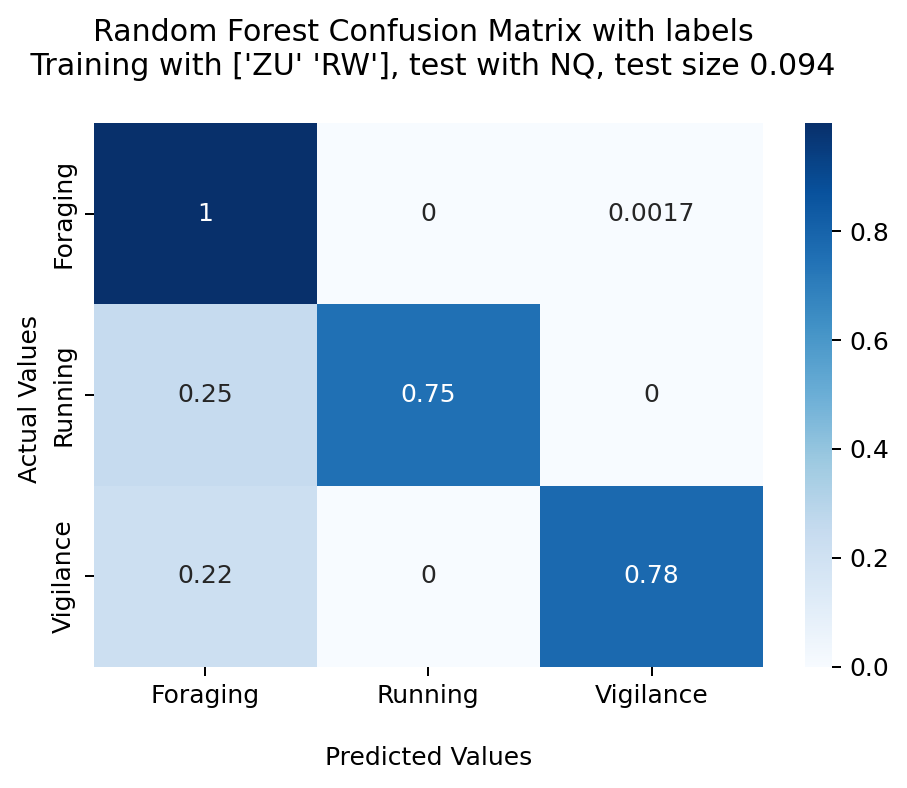

Accuracy: 0.9534195933456562


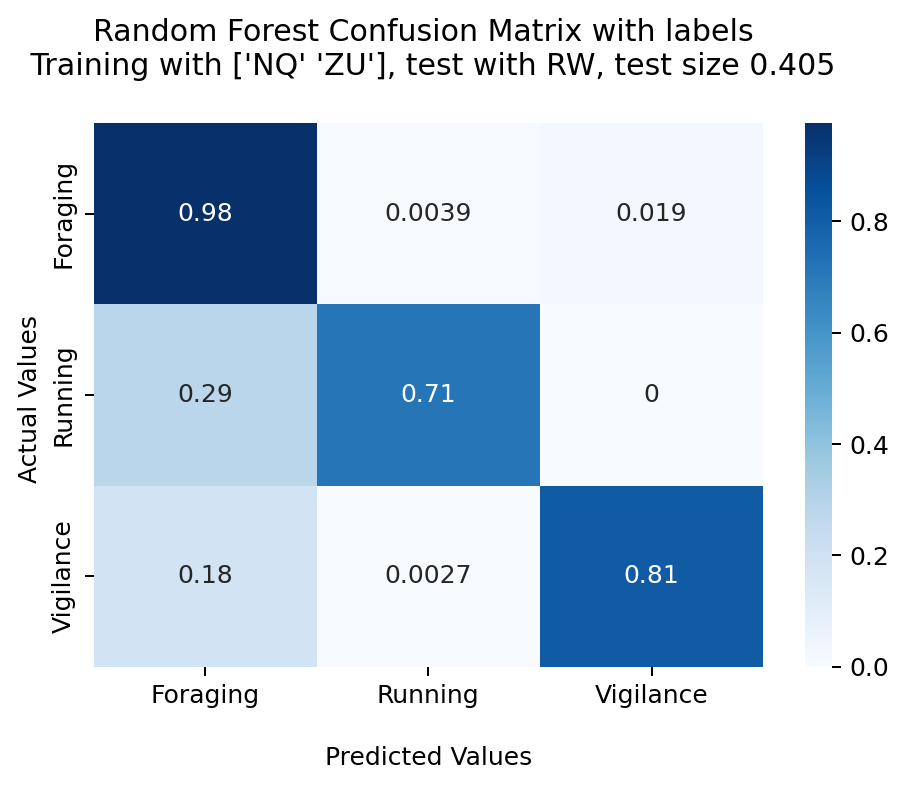

Accuracy: 0.9629251700680272


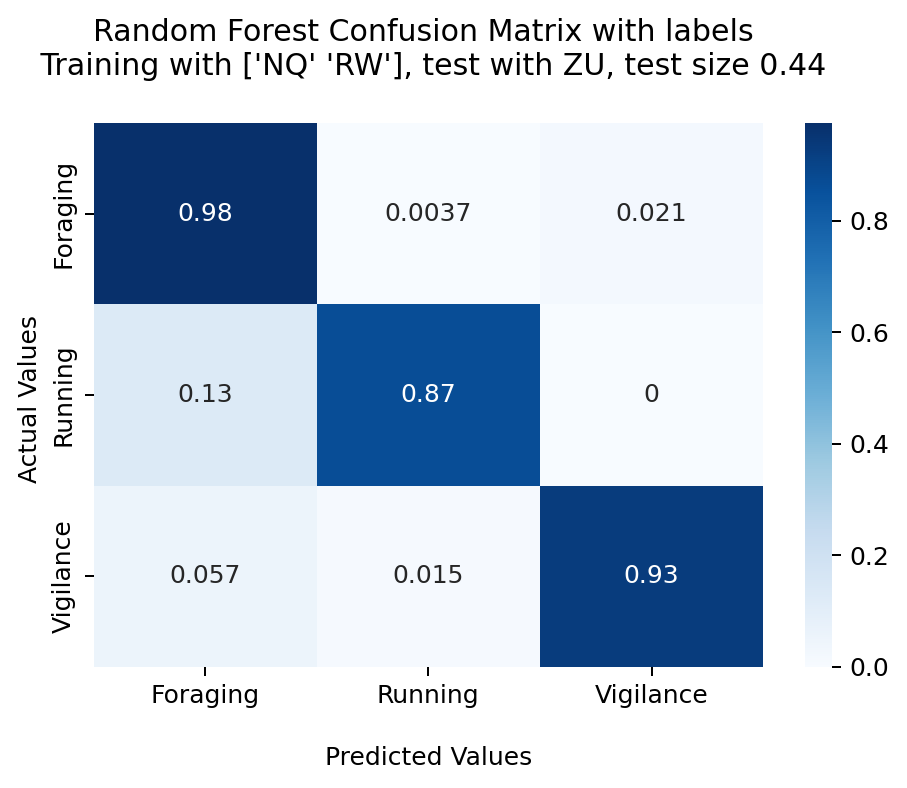

In [29]:
df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',

#df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

AVG_CF = 0
for key,value in df_copy.groupby('Group'):
    
    test_proportion = np.round(value.shape[0]/df_copy.shape[0],3)

    train_data = df_copy.drop(value.index)
    train_data = train_data[train_data['Behavior']!='Running']
    train_data.loc[train_data['Behavior']=='RunningGPS','Behavior'] = 'Running'
    x=train_data.iloc[:,4:]  # Features
    y=train_data['Behavior'].values # Labels

    Scaler = StandardScaler()
    clf=RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)


    x = Scaler.fit_transform(x)
    clf.fit(x,y)
    
    value = value[value['Behavior']!='RunningGPS']
    X_test = value.iloc[:,4:]
    y_test =  value['Behavior'].values
    X_test = Scaler.transform(X_test)
    y_pred=clf.predict(X_test)

    print("Accuracy:",accuracy_score(y_test, y_pred))

    plt.figure(dpi=180)
    cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
    AVG_CF = AVG_CF + cf_matrix
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    test_proportion = np.round(X_test.shape[0]/df_copy.shape[0],3)

    ax.set_title('Random Forest Confusion Matrix with labels \n Training with {}, test with {}, test size {}\n'.format(train_data['Group'].unique(),key,test_proportion))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(sorted(np.unique(y)))
    ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
    plt.show()

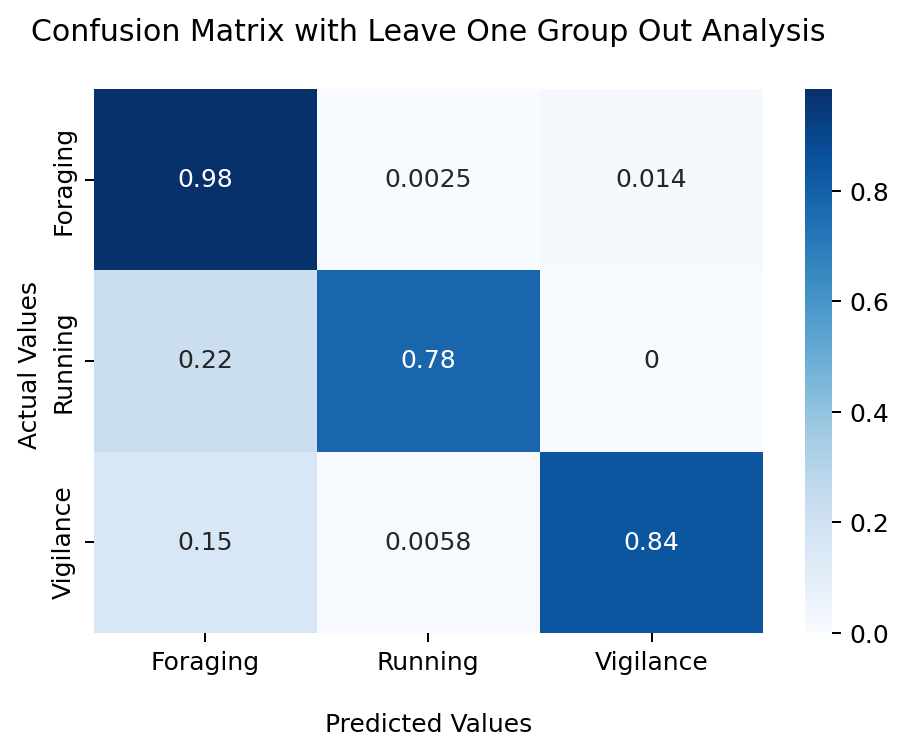

In [36]:
plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')

ax = sns.heatmap(AVG_CF/3, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with Leave One Group Out Analysis\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y)))
ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
plt.show()

Leave One Out Analysis Individual

Accuracy: 0.9844606946983546


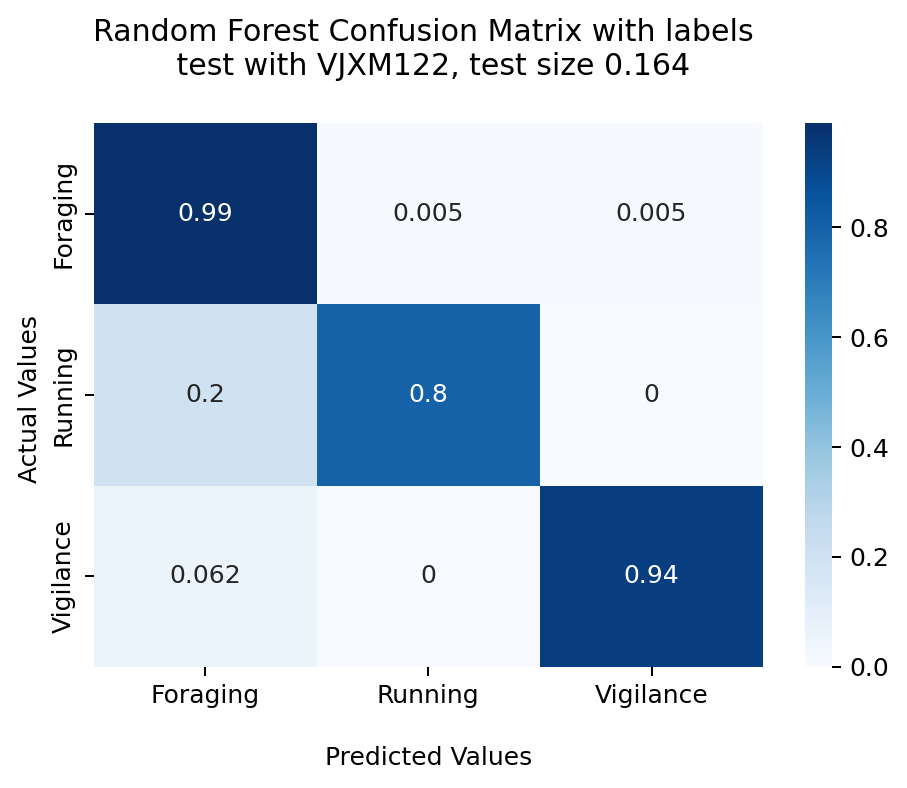

Accuracy: 0.9926739926739927


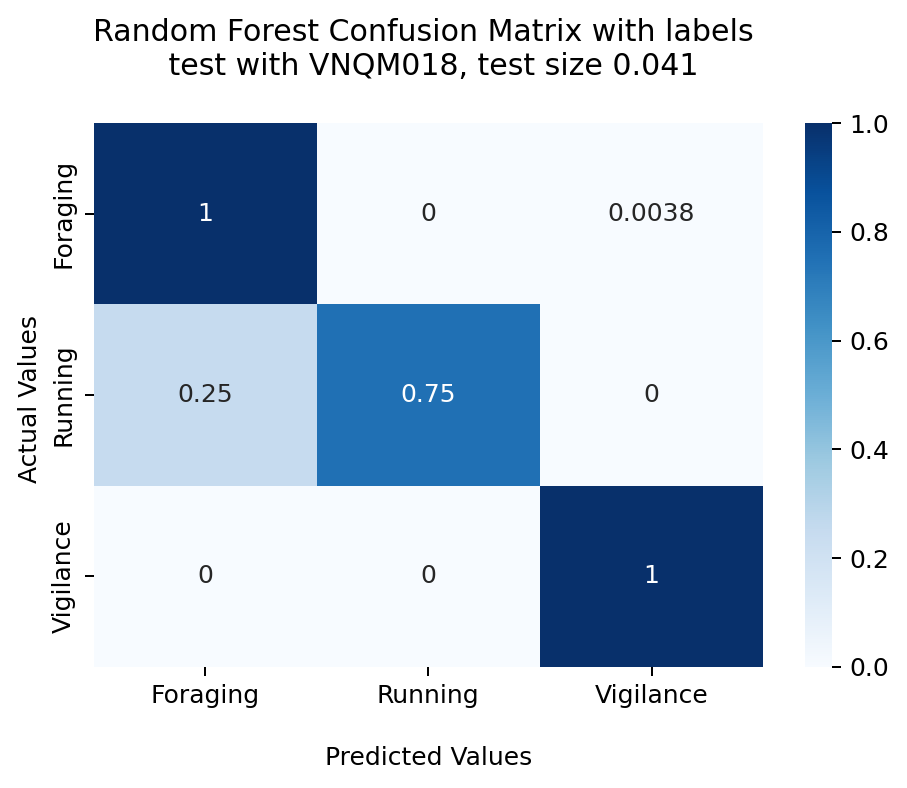

Accuracy: 0.8237547892720306


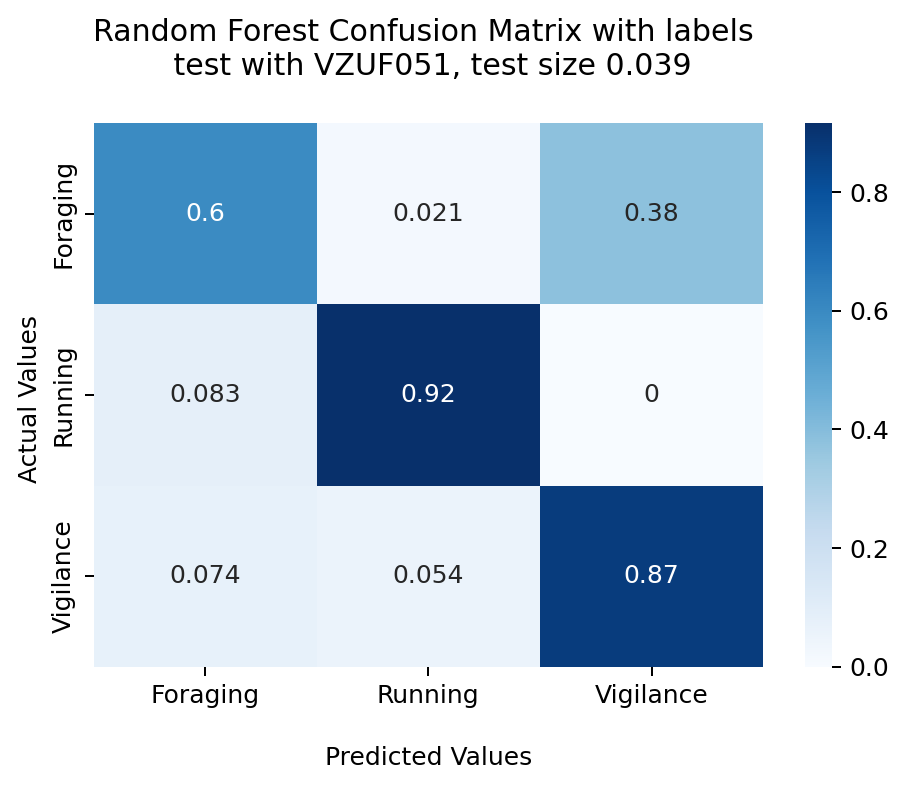

Accuracy: 0.9826446280991735


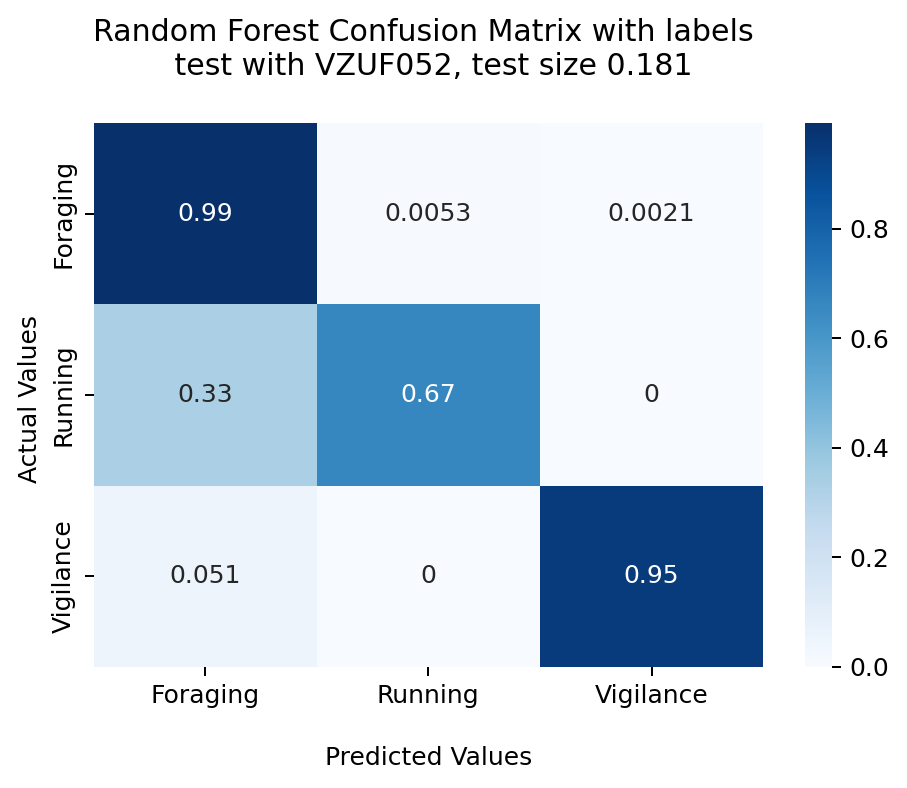

In [43]:
df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',

#df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']
Avg_cf = 0
count = 0
for key,value in df_copy.groupby('Individual'):
    
    test_proportion = np.round(value.shape[0]/df_copy.shape[0],3)
    if len(value[value['Behavior']=='Running'])>2 and len(value[value['Behavior']=='Vigilance'])>1:
        train_data = df_copy.drop(value.index)
        train_data = train_data[train_data['Behavior']!='Running']
        train_data.loc[train_data['Behavior']=='RunningGPS','Behavior'] = 'Running'
        x=train_data.iloc[:,4:]  # Features
        y=train_data['Behavior'].values # Labels
        
        Scaler = StandardScaler()
        clf=RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)


        x = Scaler.fit_transform(x)
        clf.fit(x,y)
            
        value = value[value['Behavior']!='RunningGPS']
        X_test = value.iloc[:,4:]
        y_test =  value['Behavior'].values
        X_test = Scaler.transform(X_test)
        y_pred=clf.predict(X_test)

        print("Accuracy:",accuracy_score(y_test, y_pred))

        plt.figure(dpi=180)
        
        cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
        Avg_cf = Avg_cf + cf_matrix
        count = count + 1
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

        test_proportion = np.round(X_test.shape[0]/df_copy.shape[0],3)

        ax.set_title('Random Forest Confusion Matrix with labels \n test with {}, test size {}\n'.format(key,test_proportion))
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');

        ## Ticket labels - List must be in alphabetical order
        ax.xaxis.set_ticklabels(sorted(np.unique(y)))
        ax.yaxis.set_ticklabels(sorted(np.unique(y)))
        #plt.tight_layout()
        plt.show()
    
    

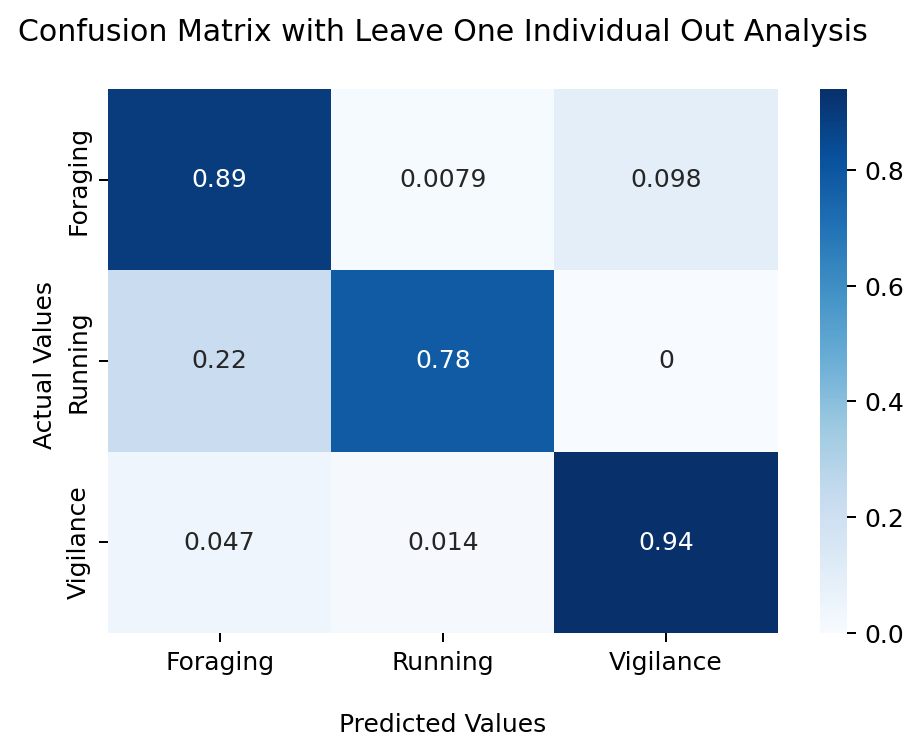

In [44]:
plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')

ax = sns.heatmap(Avg_cf/count, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with Leave One Individual Out Analysis\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y)))
ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
plt.show()

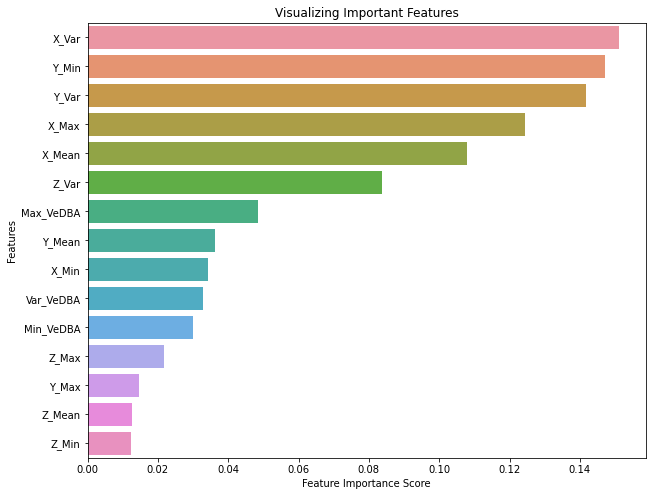

In [77]:
plt.figure(figsize=(10,8))
feature_imp = pd.Series(clf.feature_importances_,index=df_copy.iloc[:,4:].columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

# Random Forest With Stratified Kfold

In [48]:
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.metrics import confusion_matrix,classification_report,f1_score,balanced_accuracy_score
from sklearn.decomposition import PCA

df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA'],axis=1,inplace=True)
#,,'Max_VeDBA','Log VeDBA','Min_VeDBA','Var_VeDBA'
#df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']
#df_copy.loc[df_copy['Behavior'] == 'RunningGPS','Behavior'] = 'Running'

df_copy.reset_index(inplace=True,drop=True)


x=df_copy.iloc[:,4:]  # Features


y=df_copy['Behavior']  # Labels



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

f1_accu_stratified = []
balanced_accu_stratified = []



for train_index, test_index in skf.split(x, y): 
    X_train_fold, X_test_fold = x.loc[train_index], x.loc[test_index]
    Scaler = StandardScaler()
    
    X_train_fold = Scaler.fit_transform(X_train_fold)
    y_train_fold, y_test_fold = y[train_index], y[test_index] 
    
    model = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)
    model.fit(X_train_fold, y_train_fold) 
    
    X_test_fold = Scaler.transform(X_test_fold)
    y_pred_fold=model.predict(X_test_fold)
    
    balanced_accu_stratified.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
    f1_accu_stratified.append(f1_score(y_test_fold, y_pred_fold, average='macro'))
    
    
    print("Accuracy:",accuracy_score(y_test_fold, y_pred_fold))
    print(classification_report(y_test_fold, y_pred_fold))
    print('---------')
    print('\n')



print('Overall F1:',np.mean(f1_accu_stratified))
print('Overall balanced Accuracy:',np.mean(balanced_accu_stratified))


Accuracy: 0.9551569506726457
              precision    recall  f1-score   support

    Foraging       0.97      0.98      0.97      1020
     Running       0.00      0.00      0.00         5
  RunningGPS       0.86      0.83      0.85        83
   Vigilance       0.94      0.90      0.92       230

    accuracy                           0.96      1338
   macro avg       0.69      0.68      0.69      1338
weighted avg       0.95      0.96      0.95      1338

---------




/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9603590127150337
              precision    recall  f1-score   support

    Foraging       0.97      0.99      0.98      1020
     Running       0.00      0.00      0.00         5
  RunningGPS       0.86      0.85      0.86        82
   Vigilance       0.96      0.90      0.93       230

    accuracy                           0.96      1337
   macro avg       0.70      0.69      0.69      1337
weighted avg       0.96      0.96      0.96      1337

---------




/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9648466716529543
              precision    recall  f1-score   support

    Foraging       0.97      0.99      0.98      1019
     Running       0.00      0.00      0.00         6
  RunningGPS       0.93      0.90      0.91        82
   Vigilance       0.93      0.92      0.93       230

    accuracy                           0.96      1337
   macro avg       0.71      0.70      0.71      1337
weighted avg       0.96      0.96      0.96      1337

---------




/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9566192969334331
              precision    recall  f1-score   support

    Foraging       0.96      0.99      0.98      1019
     Running       0.00      0.00      0.00         5
  RunningGPS       0.88      0.86      0.87        83
   Vigilance       0.97      0.87      0.91       230

    accuracy                           0.96      1337
   macro avg       0.70      0.68      0.69      1337
weighted avg       0.95      0.96      0.95      1337

---------


Accuracy: 0.9581151832460733
              precision    recall  f1-score   support

    Foraging       0.97      0.98      0.98      1019
     Running       0.00      0.00      0.00         5
  RunningGPS       0.86      0.94      0.90        83
   Vigilance       0.94      0.88      0.91       230

    accuracy                           0.96      1337
   macro avg       0.69      0.70      0.70      1337
weighted avg       0.95      0.96      0.96      1337

---------


Overall F1: 0.6933725676340892
Overall balanced 

/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amlan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

<ipython-input-52-1d414f7c1086>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'


Accuracy: 0.9602349751468595


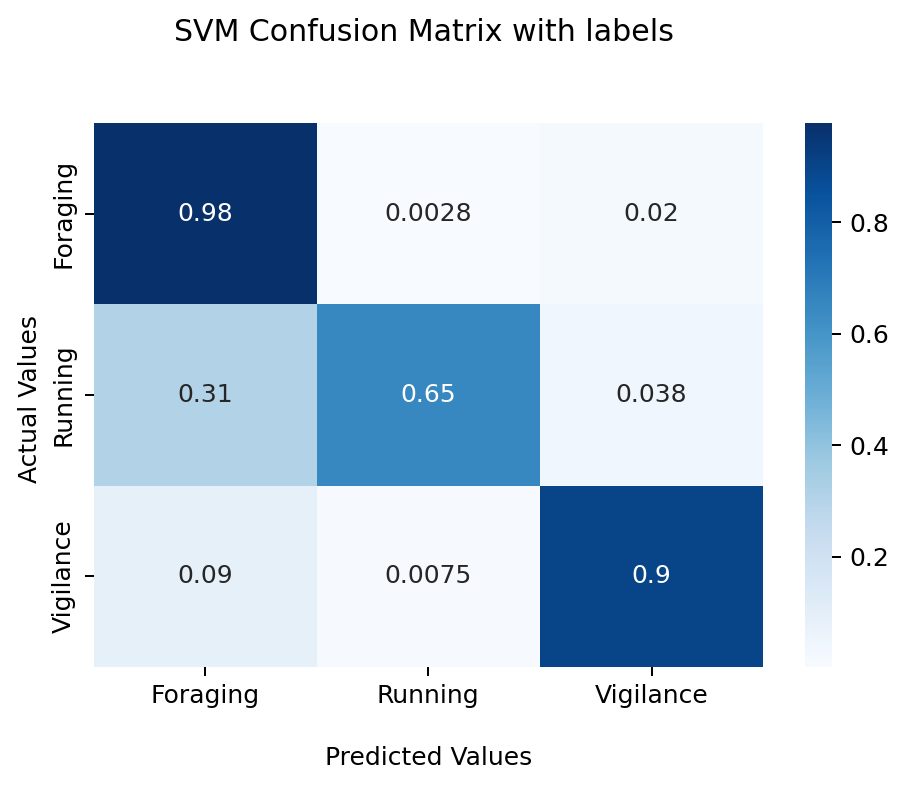

              precision    recall  f1-score   support

    Foraging       0.98      0.98      0.98      1786
     Running       0.68      0.65      0.67        26
   Vigilance       0.91      0.90      0.91       401

    accuracy                           0.96      2213
   macro avg       0.85      0.84      0.85      2213
weighted avg       0.96      0.96      0.96      2213



In [52]:

df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',
df_GPS_RUNNING = df_copy[df_copy['Behavior']=='RunningGPS']
df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'

df_RUNNING =  df_copy[df_copy['Behavior']=='Running']

df_copy = df_copy[df_copy['Behavior']!='RunningGPS']
df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

x=df_copy.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df_copy['Behavior'].values  # Labels


Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35,random_state=42) # 80% training and 20% test



clf=SVC(kernel='linear', gamma='scale',random_state=42)


X_train =  np.concatenate((X_train, df_GPS_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_train = np.concatenate([y_train,df_GPS_RUNNING['Behavior'].to_numpy()],axis=0)


X_test =  np.concatenate((X_test, df_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_test = np.concatenate([y_test,df_RUNNING['Behavior'].to_numpy()],axis=0)

X_train = Scaler.fit_transform(X_train)

clf.fit(X_train,y_train)


X_test = Scaler.transform(X_test)

y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('SVM Confusion Matrix with labels \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y_train)))
ax.yaxis.set_ticklabels(sorted(np.unique(y_train)))
#plt.tight_layout()
plt.show()


print(classification_report(y_test, y_pred))




Accuracy: 0.9713375796178344


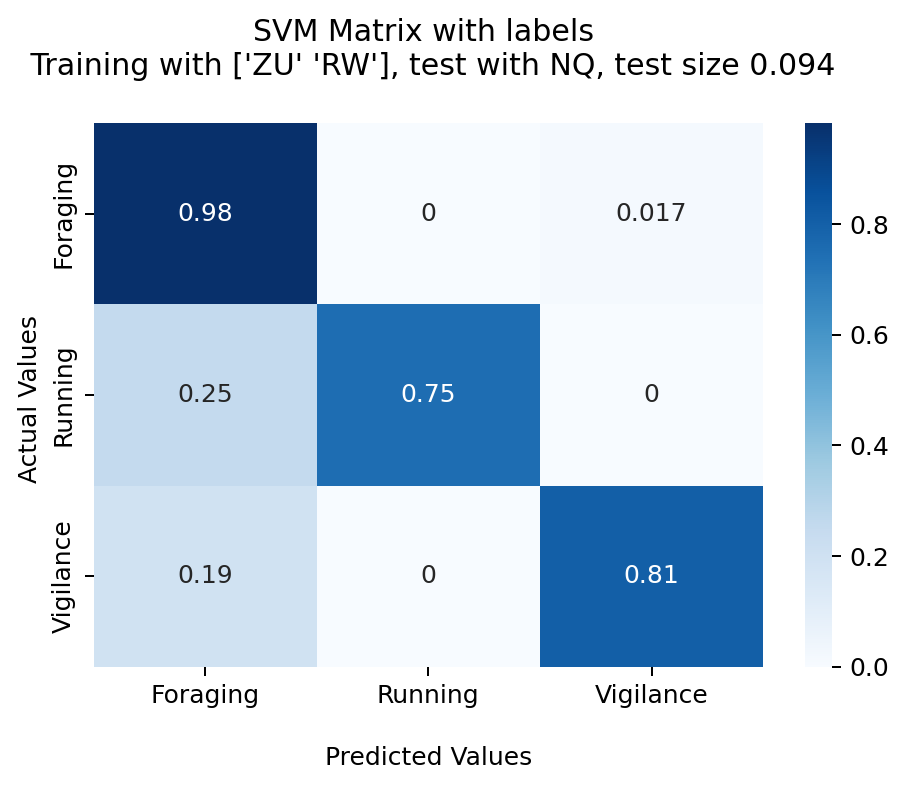

Accuracy: 0.956746765249538


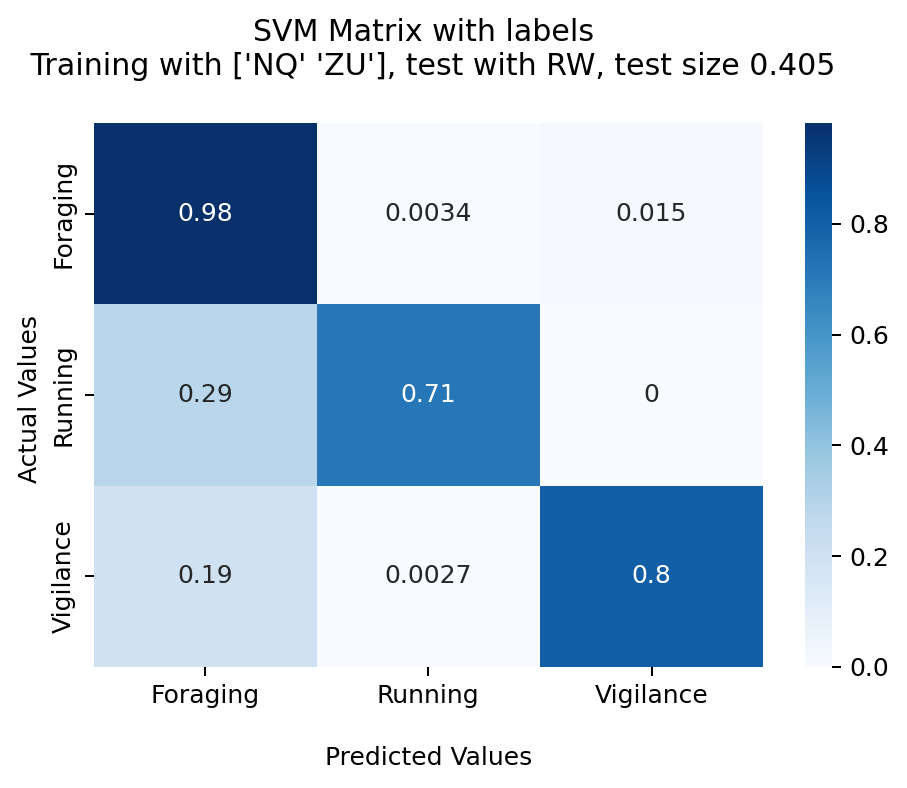

Accuracy: 0.9554421768707483


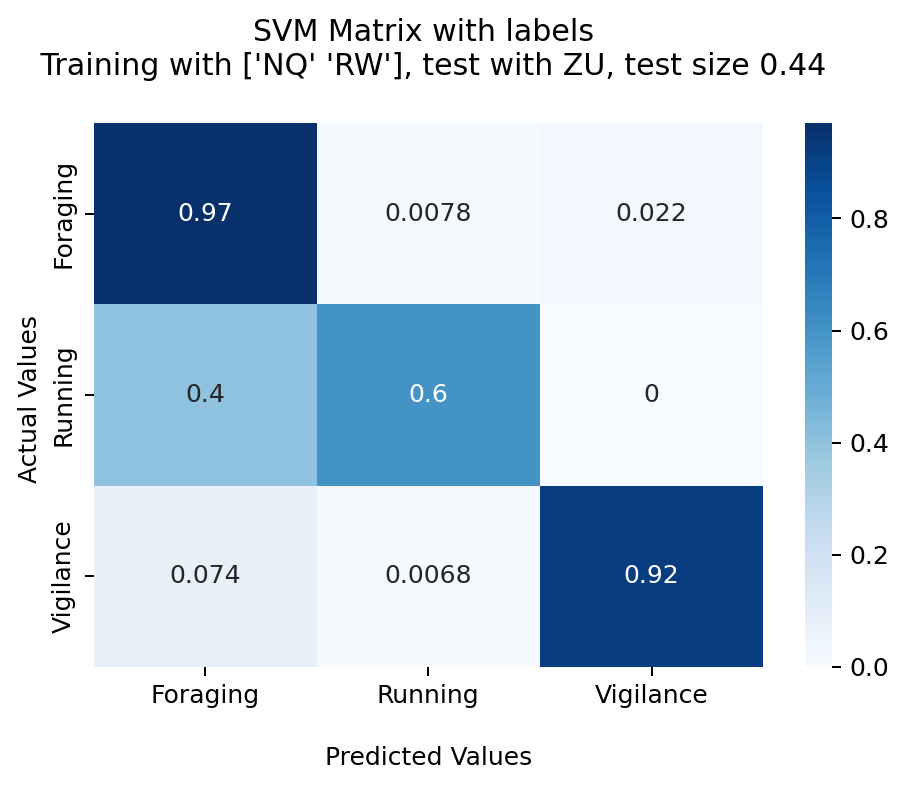

In [54]:
df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',

#df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

AVG_CF = 0
for key,value in df_copy.groupby('Group'):
    
    test_proportion = np.round(value.shape[0]/df_copy.shape[0],3)

    train_data = df_copy.drop(value.index)
    train_data = train_data[train_data['Behavior']!='Running']
    train_data.loc[train_data['Behavior']=='RunningGPS','Behavior'] = 'Running'
    x=train_data.iloc[:,4:]  # Features
    y=train_data['Behavior'].values # Labels

    Scaler = StandardScaler()
    clf=clf=SVC(kernel='linear', gamma='scale',random_state=42)


    x = Scaler.fit_transform(x)
    clf.fit(x,y)
    
    value = value[value['Behavior']!='RunningGPS']
    X_test = value.iloc[:,4:]
    y_test =  value['Behavior'].values
    X_test = Scaler.transform(X_test)
    y_pred=clf.predict(X_test)

    print("Accuracy:",accuracy_score(y_test, y_pred))

    plt.figure(dpi=180)
    cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
    AVG_CF = AVG_CF + cf_matrix
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    test_proportion = np.round(X_test.shape[0]/df_copy.shape[0],3)

    ax.set_title('SVM Matrix with labels \n Training with {}, test with {}, test size {}\n'.format(train_data['Group'].unique(),key,test_proportion))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(sorted(np.unique(y)))
    ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
    plt.show()

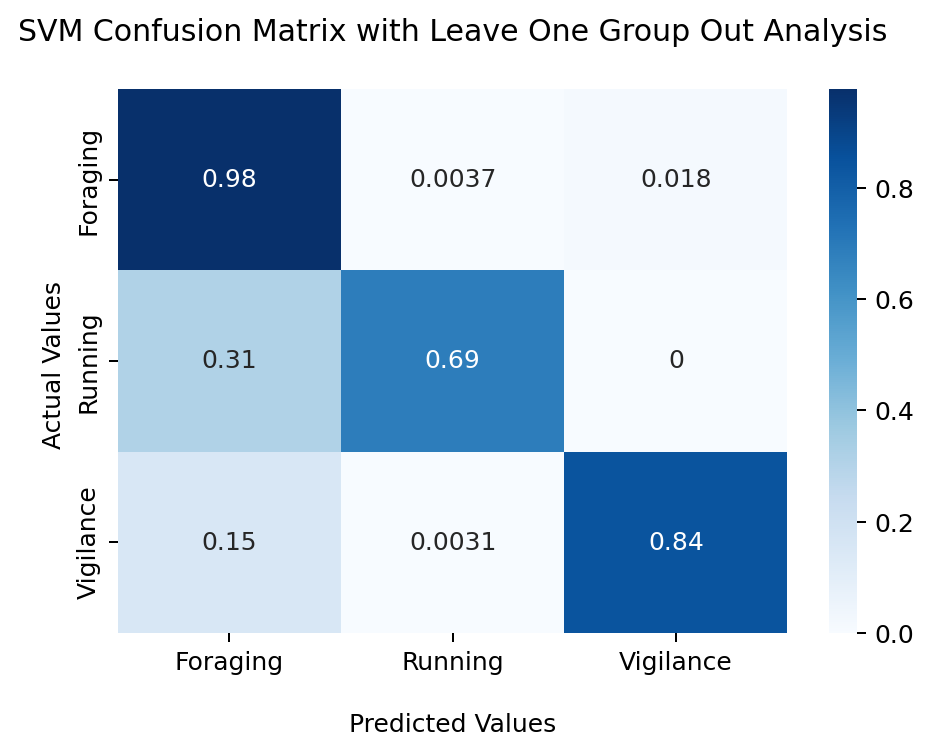

In [56]:
plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')

ax = sns.heatmap(AVG_CF/3, annot=True, cmap='Blues')

ax.set_title('SVM Confusion Matrix with Leave One Group Out Analysis\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y)))
ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
plt.show()

KNN

<ipython-input-59-264f68ca3ba9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'


Accuracy: 0.9647537279710799


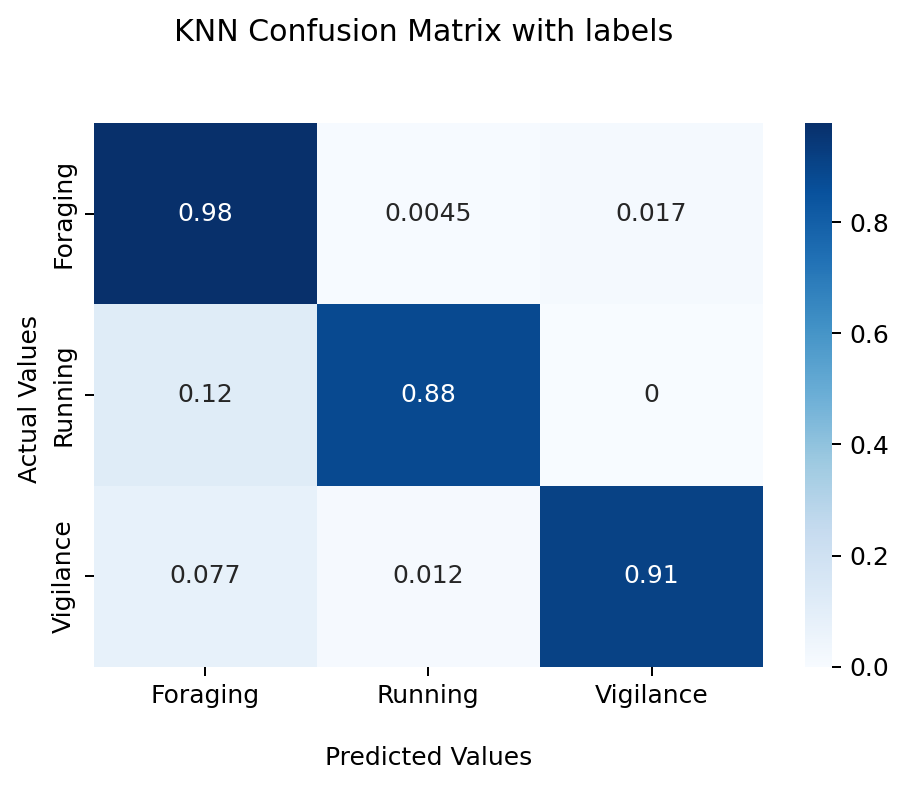

              precision    recall  f1-score   support

    Foraging       0.98      0.98      0.98      1786
     Running       0.64      0.88      0.74        26
   Vigilance       0.92      0.91      0.92       401

    accuracy                           0.96      2213
   macro avg       0.85      0.92      0.88      2213
weighted avg       0.97      0.96      0.97      2213



In [59]:
from sklearn.neighbors import KNeighborsClassifier

df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',
df_GPS_RUNNING = df_copy[df_copy['Behavior']=='RunningGPS']
df_GPS_RUNNING.loc[:,'Behavior'] = 'Running'

df_RUNNING =  df_copy[df_copy['Behavior']=='Running']

df_copy = df_copy[df_copy['Behavior']!='RunningGPS']
df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

x=df_copy.iloc[:,4:]  # Features
#x=df.iloc[:,4:]  # Features

y=df_copy['Behavior'].values  # Labels


Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35,random_state=42) # 80% training and 20% test


clf=KNeighborsClassifier(n_neighbors=15)


X_train =  np.concatenate((X_train, df_GPS_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_train = np.concatenate([y_train,df_GPS_RUNNING['Behavior'].to_numpy()],axis=0)


X_test =  np.concatenate((X_test, df_RUNNING.iloc[:,4:].to_numpy()), axis = 0)
y_test = np.concatenate([y_test,df_RUNNING['Behavior'].to_numpy()],axis=0)

X_train = Scaler.fit_transform(X_train)

clf.fit(X_train,y_train)


X_test = Scaler.transform(X_test)

y_pred=clf.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('KNN Confusion Matrix with labels \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y_train)))
ax.yaxis.set_ticklabels(sorted(np.unique(y_train)))
#plt.tight_layout()
plt.show()


print(classification_report(y_test, y_pred))


Accuracy: 0.9777070063694268


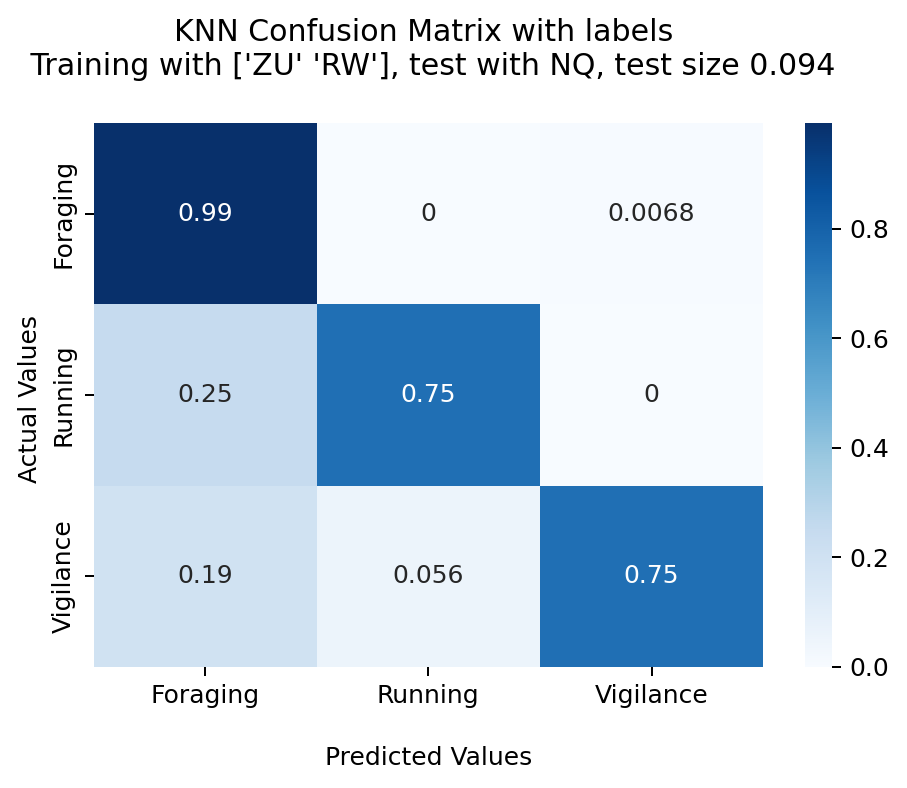

Accuracy: 0.9560073937153419


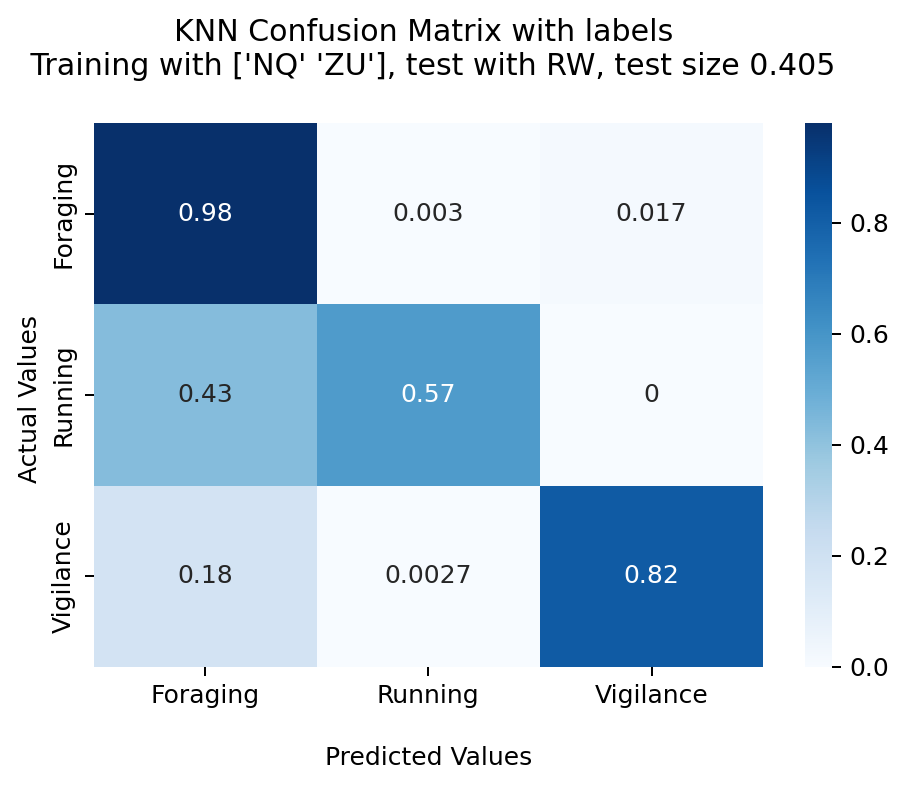

Accuracy: 0.9595238095238096


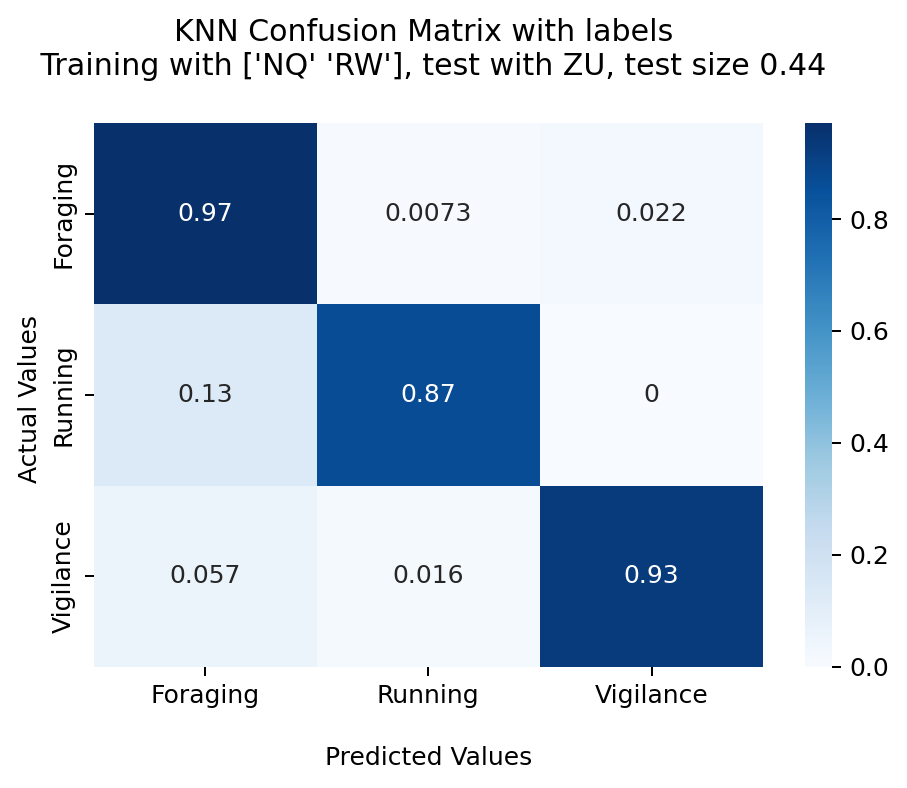

In [61]:
df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA','StdNorm'],axis=1,inplace=True)
#'Max_VeDBA','Min_VeDBA',

#df_copy = df_copy[df_copy['Behavior']!='Running']
df_copy = df_copy[df_copy['Behavior']!='Others']

AVG_CF = 0
for key,value in df_copy.groupby('Group'):
    
    test_proportion = np.round(value.shape[0]/df_copy.shape[0],3)

    train_data = df_copy.drop(value.index)
    train_data = train_data[train_data['Behavior']!='Running']
    train_data.loc[train_data['Behavior']=='RunningGPS','Behavior'] = 'Running'
    x=train_data.iloc[:,4:]  # Features
    y=train_data['Behavior'].values # Labels

    Scaler = StandardScaler()
    clf=KNeighborsClassifier(n_neighbors=15)


    x = Scaler.fit_transform(x)
    clf.fit(x,y)
    
    value = value[value['Behavior']!='RunningGPS']
    X_test = value.iloc[:,4:]
    y_test =  value['Behavior'].values
    X_test = Scaler.transform(X_test)
    y_pred=clf.predict(X_test)

    print("Accuracy:",accuracy_score(y_test, y_pred))

    plt.figure(dpi=180)
    cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')
    AVG_CF = AVG_CF + cf_matrix
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    test_proportion = np.round(X_test.shape[0]/df_copy.shape[0],3)

    ax.set_title('KNN Confusion Matrix with labels \n Training with {}, test with {}, test size {}\n'.format(train_data['Group'].unique(),key,test_proportion))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(sorted(np.unique(y)))
    ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
    plt.show()

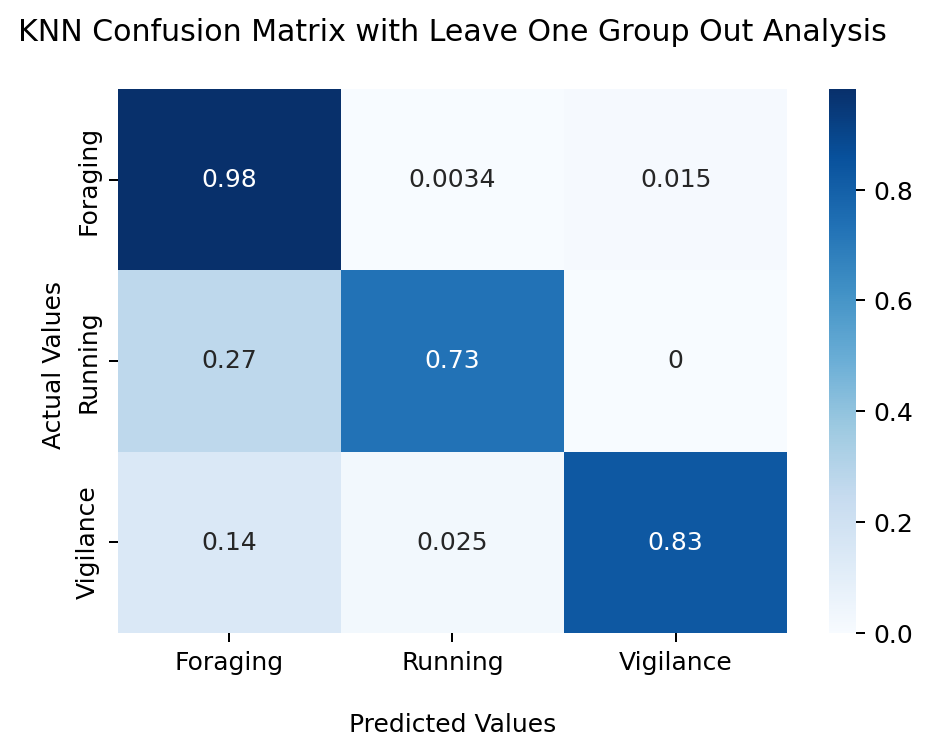

In [62]:
plt.figure(dpi=180)
cf_matrix = confusion_matrix(y_test, y_pred,normalize='true')

ax = sns.heatmap(AVG_CF/3, annot=True, cmap='Blues')

ax.set_title('KNN Confusion Matrix with Leave One Group Out Analysis\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(sorted(np.unique(y)))
ax.yaxis.set_ticklabels(sorted(np.unique(y)))
    #plt.tight_layout()
plt.show()

ALL

In [51]:
df_copy = df.copy()
df_copy.drop(['Axy','Log VeDBA'],axis=1,inplace=True)
df_copy = df_copy.loc[df_copy['Behavior']!='Running']
df_copy.loc[df_copy['Behavior'] == 'RunningGPS','Behavior'] = 'Running'
df_copy = df_copy.loc[df_copy['Behavior']!='Others']

df_copy.reset_index(inplace=True,drop=True)


x=df_copy.iloc[:,4:]  # Features


y=df_copy['Behavior']  # Labels



Scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42) # 80% training and 20% test

X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

Models = [RandomForestClassifier(),KNeighborsClassifier(),SVC(),GradientBoostingClassifier()]

for clf in Models:

    print(clf)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 
    f1_accu_stratified = []
    balanced_accu_stratified = []



    for train_index, test_index in skf.split(x, y): 
        X_train_fold, X_test_fold = x.loc[train_index], x.loc[test_index]
        Scaler = StandardScaler()

        X_train_fold = Scaler.fit_transform(X_train_fold)
        y_train_fold, y_test_fold = y[train_index], y[test_index] 

        model = clf
        model.fit(X_train_fold, y_train_fold) 

        X_test_fold = Scaler.transform(X_test_fold)
        y_pred_fold=model.predict(X_test_fold)

        balanced_accu_stratified.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
        f1_accu_stratified.append(f1_score(y_test_fold, y_pred_fold, average='macro'))


        
        print(classification_report(y_test_fold, y_pred_fold))

    print('Overall F1:',np.mean(f1_accu_stratified))
    print('Overall balanced Accuracy:',np.mean(balanced_accu_stratified))

    print('\n')

NameError: name 'GradientBoostingClassifier' is not defined